# Import du Dataset

In [6]:
import pandas as pd

df = pd.read_csv('../data/train.csv')
df

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,INLAND
1,10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
2,2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,INLAND
3,4284,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,<1H OCEAN
4,16541,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,INLAND
...,...,...,...,...,...,...,...,...,...,...,...
16507,1099,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,3.0625,93800.0,INLAND
16508,18898,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,2.6133,103100.0,NEAR BAY
16509,11798,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,4.4958,192600.0,INLAND
16510,6637,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,2.5750,153500.0,<1H OCEAN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16512 non-null  int64  
 1   longitude           16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   housing_median_age  16512 non-null  float64
 4   total_rooms         16512 non-null  float64
 5   total_bedrooms      16336 non-null  float64
 6   population          16512 non-null  float64
 7   households          16512 non-null  float64
 8   median_income       16512 non-null  float64
 9   median_house_value  16512 non-null  float64
 10  ocean_proximity     16512 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.4+ MB


In [8]:
df.isna().sum()

Unnamed: 0              0
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        176
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

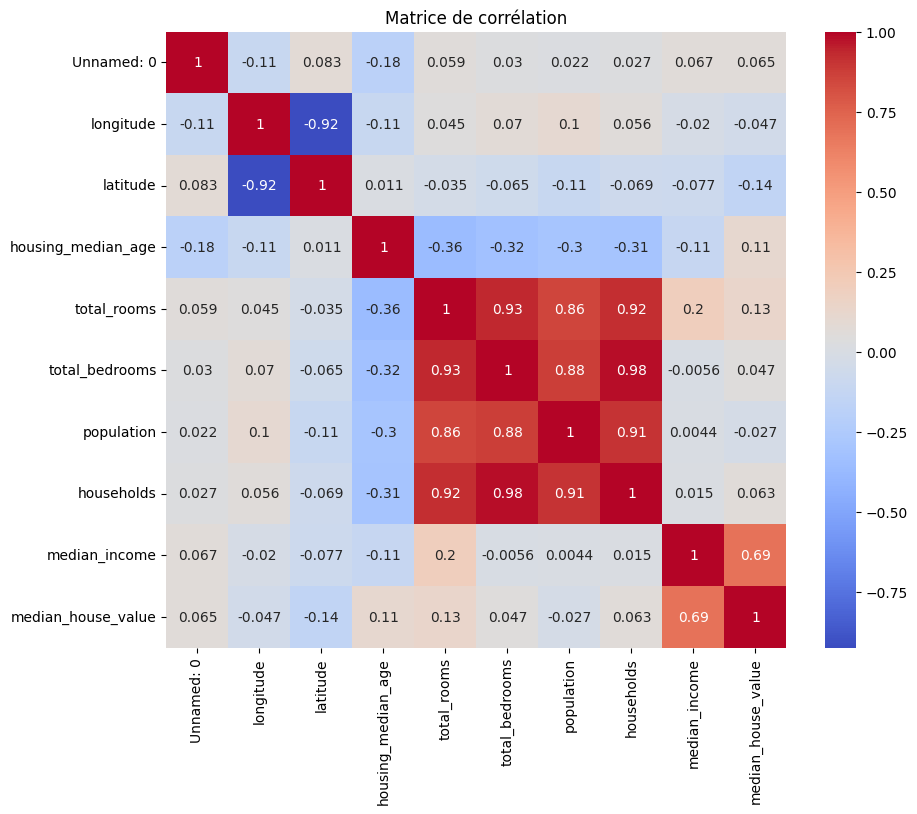

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = df.select_dtypes(include=['float64', "int64"]).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))  # ⬅️ largeur = 10, hauteur = 8 (ajuste à ton goût)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")  # tu peux aussi jouer sur le style
plt.title("Matrice de corrélation")  # optionnel
plt.show()

df = df.drop(["households", "total_bedrooms", "Unnamed: 0", "population"], axis=1)

# Preprocessing

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler


X = df.copy()
y = X.pop('median_house_value')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes('object').columns


numerical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline, numerical_features),
    ('categorical_pipeline', categorical_pipeline, categorical_features)
], remainder='drop', n_jobs=-1)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

model = RandomForestRegressor(n_jobs=-1)
reg = Pipeline(steps = [('preprocessor', preprocessor),
                           ("model", model)])


reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE) :', mae)
print('Mean Squared Error (MSE) :', mse)
print('Root Mean Squared Error (RMSE) :', rmse)
print('R-squared (R²) :', r_squared)

Mean Absolute Error (MAE) : 32890.448599743075
Mean Squared Error (MSE) : 2593455572.479277
Root Mean Squared Error (RMSE) : 50925.9813109112
R-squared (R²) : 0.8066040545531179


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(reg, X_train, y_train, cv = 5)
print('Cross Validation :', scores, '\nMoyenne :', scores.mean())

Cross Validation : [0.79329202 0.79238834 0.80828057 0.80579645 0.81094241] 
Moyenne : 0.8021399565272682


# Feature Selection

In [14]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import LabelEncoder

X = df.copy()
X['ocean_proximity'] = LabelEncoder().fit_transform(X['ocean_proximity'])
y = X.pop('median_house_value')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rfe = RFECV(model,cv=5,scoring="neg_mean_squared_error")

rfe.fit(X_train,y_train)

RFECV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
      scoring='neg_mean_squared_error')

In [15]:
rfe.support_

array([ True,  True, False, False,  True, False])

In [16]:
rfe.ranking_

array([1, 1, 3, 4, 1, 2])

In [17]:
features = list(X.columns)
selected_features = list(np.array(features)[rfe.get_support()])
print('Meilleurs features à garder :', selected_features)

Meilleurs features à garder : [np.str_('longitude'), np.str_('latitude'), np.str_('median_income')]


# Model Tuning

In [18]:
X = df.copy()
y = X.pop('median_house_value')

X = df[selected_features]
y = np.log(y)

numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes('object').columns


numerical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline, numerical_features),
    ('categorical_pipeline', categorical_pipeline, categorical_features)
], remainder='drop', n_jobs=-1)

In [19]:
from sklearn.model_selection import GridSearchCV

# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Hyperparamètres
n_estimators = [100, 150, 200, 250, 300]
max_features = ['auto', 'sqrt', 'log2']
max_depth = list(range(10, 21))  # 10 à 20 inclus

parameters = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth
}

# Modèle
model = RandomForestRegressor(n_jobs=-1)

# Pipeline avec preprocessing
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# GridSearchCV
grid_search = GridSearchCV(reg, parameters, cv=5, scoring='r2', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Évaluation
y_pred = best_model.predict(X_test)
r2_accuracy = r2_score(y_test, y_pred)
crossval = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2').mean()

print(f"R2 sur test set : {r2_accuracy:.4f}")
print(f"Cross-val R2 (train) : {crossval:.4f}")
print("Meilleurs hyperparamètres :", grid_search.best_params_)

c:\Users\Utilisateur\.virtualenvs\housing_prediction-n2inHCju\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
275 fits failed out of a total of 825.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
134 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\.virtualenvs\housing_prediction-n2inHCju\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\.virtualenvs\housing_prediction-n2inHCju\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

R2 sur test set : 0.8351
Cross-val R2 (train) : 0.8257
Meilleurs hyperparamètres : {'model__max_depth': 20, 'model__max_features': 'log2', 'model__n_estimators': 300}


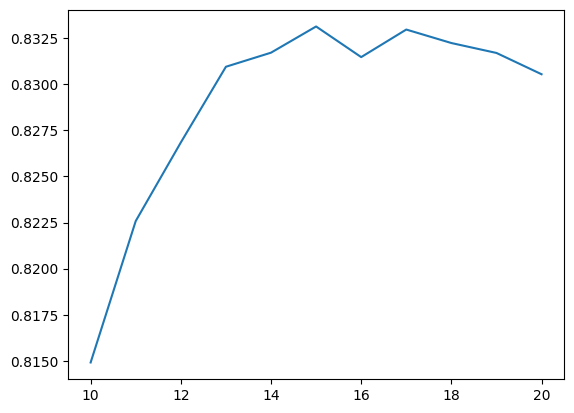

In [20]:
import matplotlib.pyplot as plt

depth = [10,11,12,13,14,15,16,17,18,19,20]
scores = []
for n in depth:
    model = RandomForestRegressor(max_depth=n)
    neigh = Pipeline(steps = [('preprocessor', preprocessor),
                           ("model", model)])

    neigh.fit(X_train, y_train)
    scores.append(neigh.score(X_test, y_test))

plt.plot(depth, scores)
plt.show()

# Export du model

In [22]:
import joblib

# Exemple de création et d'entraînement du modèle
best_model.fit(X_train, y_train)

# Sauvegarde du modèle complet (pipeline)
joblib.dump(best_model, '../model/model_california.joblib', compress=3)
print("Modèle sauvegardé sous 'model_california.joblib'")

Modèle sauvegardé sous 'model_california.joblib'
